In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pathlib
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.v2 as transforms
import lightning
import lightning.pytorch.callbacks as callbacks

import diffsci.models

In [9]:
MAINFOLDER = pathlib.Path("../..")  # This leads to the main folder
DATAFOLDER = MAINFOLDER/"saveddata"  # This leads to the data folder
MODELSFOLDER = MAINFOLDER/"savedmodels" #This leads to the models folder
EXTERNALDATAFOLDER = DATAFOLDER/'external'  # This leads to the external data folder

In [37]:
class UnlabeledMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        x, y = self.mnist_dataset[idx]
        return x, y

mnist_dataset = torchvision.datasets.MNIST(EXTERNALDATAFOLDER,
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

unlabeled_mnist_dataset = UnlabeledMNISTDataset(mnist_dataset)


In [38]:
batch_size = 16
p_split = 0.8
num_workers = multiprocessing.cpu_count() - 2

num_train_dataset = int(len(unlabeled_mnist_dataset)*p_split)
num_valid_dataset = len(unlabeled_mnist_dataset) - num_train_dataset
train_dataset, val_dataset = torch.utils.data.random_split(unlabeled_mnist_dataset,
                                                           [num_train_dataset, num_valid_dataset])
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)

In [39]:
next(iter(train_dataloader))[1].shape

torch.Size([16])

In [59]:
class SwiGLUMLP(torch.nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 n_hidden):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_features, 2 * n_hidden)
        self.linear2 = torch.nn.Linear(n_hidden, out_features)

    def forward(self, x):
        y = self.linear1(x)
        y = torch.chunk(y, 2, dim=-1)
        y = torch.nn.functional.silu(y[0]) * y[1]
        y = self.linear2(y)
        return y


class Embedder(torch.nn.Module):
    def __init__(self,
                 ntokens: int = 10,
                 dembed: int = 32,
                 ffn_expansion: int = 4,
                 ):
        super().__init__()
        self.embedding = torch.nn.Embedding(ntokens, dembed)
        self.net = SwiGLUMLP(dembed, dembed, dembed*ffn_expansion)

    def forward(self, x):
        xe = self.embedding(x)
        y = self.net(xe)
        return y + xe

embedder = Embedder()


In [60]:
modelconfig = diffsci.models.PUNetGConfig(model_channels=32)
model = diffsci.models.PUNetG(modelconfig, conditional_embedding=embedder)
moduleconfig = diffsci.models.KarrasModuleConfig.from_edm()
module = diffsci.models.KarrasModule(model, moduleconfig, conditional=True)
optimizer = torch.optim.Adam(module.parameters(), lr=1e-3)
module.set_optimizer_and_scheduler(optimizer)

In [61]:
trainer = lightning.Trainer(max_epochs=10, enable_checkpointing=False)
trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params | Mode 
--------------------------------------------------
0 | model       | PUNetG    | 2.8 M  | train
1 | loss_metric | HuberLoss | 0      | train
--------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.392    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/dfnaiff/miniconda3/envs/ddpm_env/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [56]:
sample = module.sample(nsamples=1, shape=[1, 28, 28], y=torch.tensor(1))

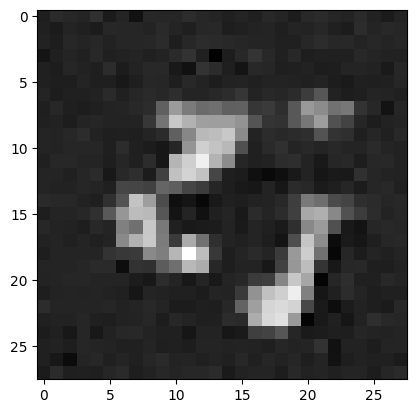

In [57]:
plt.imshow(sample.squeeze().cpu().numpy(), cmap="gray")